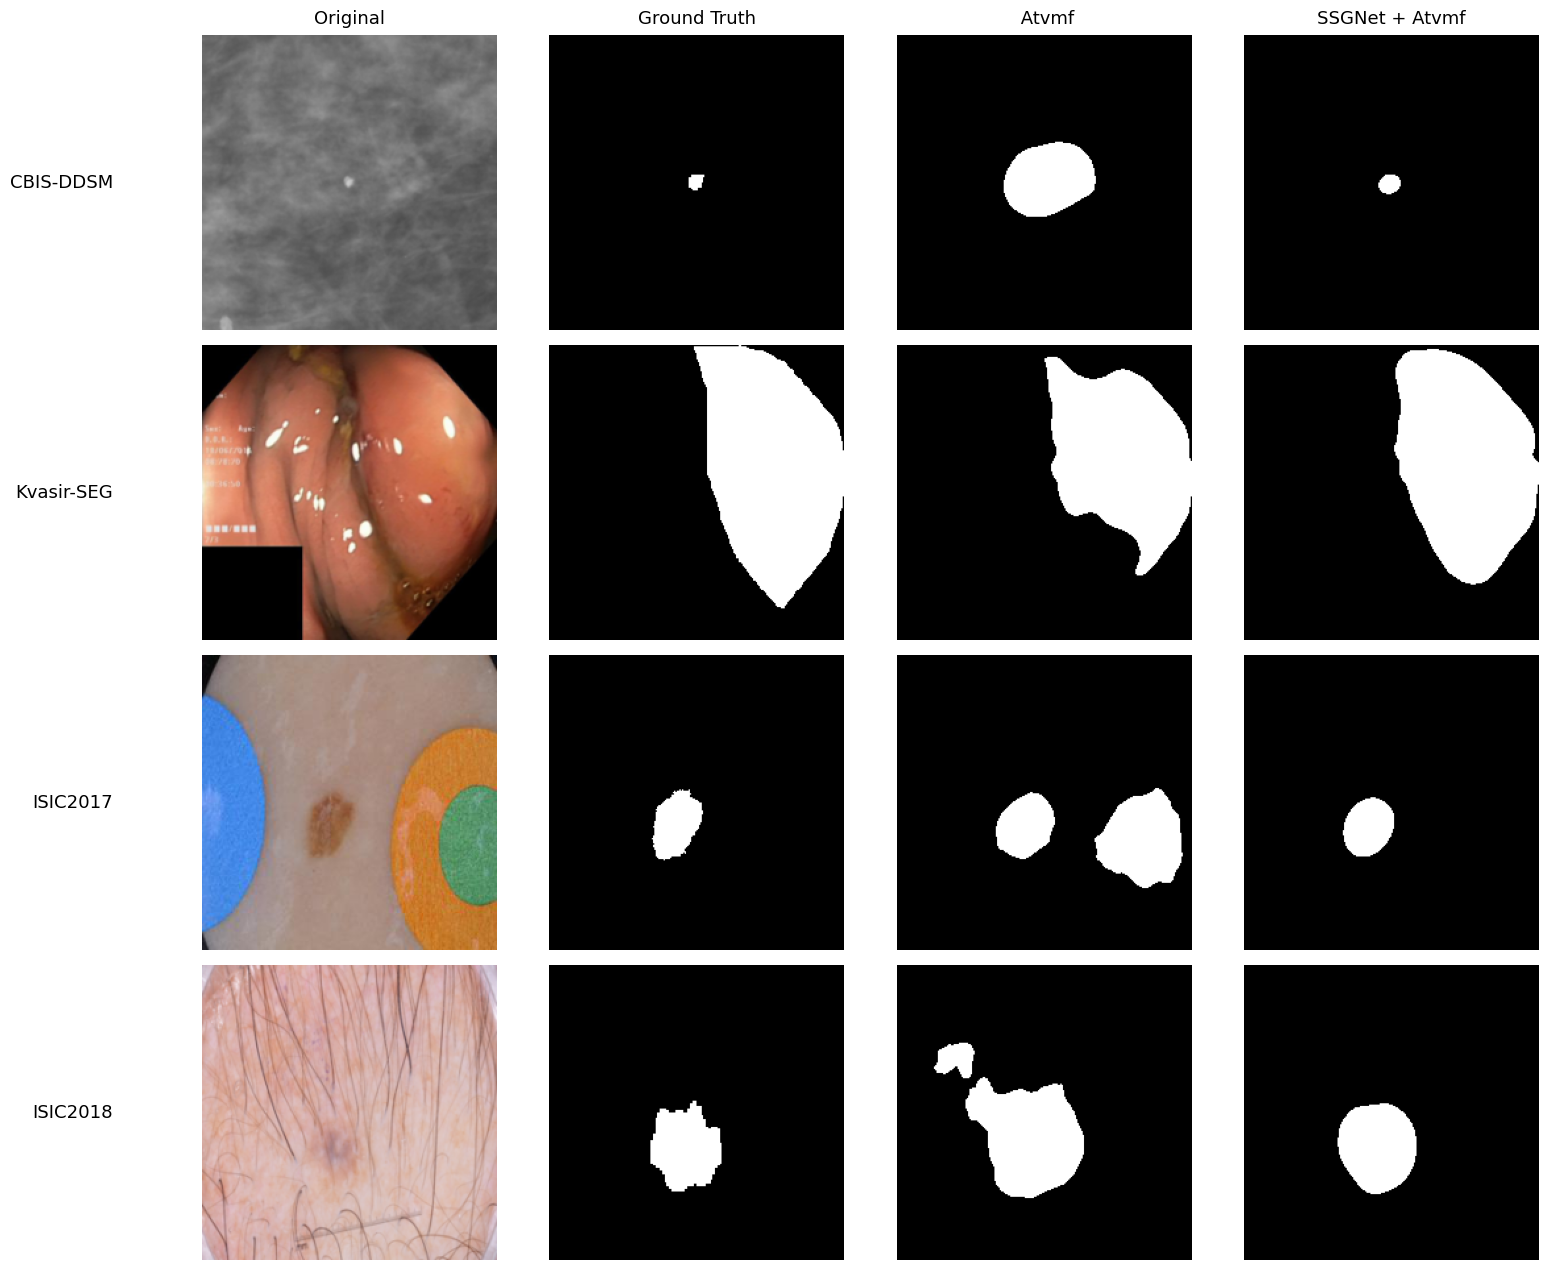

Saved grid to: segmentation_comparison_grid.png


In [1]:
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# ---- Root folder containing the 4 subfolders ----
ROOT = Path("results")  # e.g., results/cbis, results/kvasir, results/2017, results/2018

# ---- Subfolders -> pretty names shown on the left ----
ROWS = [
    ("cbis",  "CBIS-DDSM"),
    ("kvasir","Kvasir-SEG"),
    ("isic2017",  "ISIC2017"),
    ("isic2018",  "ISIC2018"),
]

# ---- Column keys inside each subfolder and their titles ----
# Expect files named like: og.png, GT.png, atvmf.png, ours.png (any of .png/.jpg/.jpeg; case-insensitive)
COLUMNS = ["og", "GT", "atvmf", "ours"]
COLUMN_TITLES = ["Original", "Ground Truth", " Atvmf", "SSGNet + Atvmf"]

# ---- Robust image loader: case-insensitive key, tries multiple extensions ----
def load_image_from_subdir(subdir: Path, key: str):
    # Accept small set of aliases for safety (e.g., "gt" or "GT")
    aliases = {
        "og": ["og", "orig", "original"],
        "GT": ["gt", "GT", "mask", "label"],
        "atvmf": ["atvmf", "baseline", "adaptive", "tvmf"],
        "ours": ["ours", "ssgnet", "ssg", "proposed"],
    }
    exts = [".png", ".jpg", ".jpeg"]

    candidates = []
    for alias in aliases.get(key, [key]):
        for ext in exts:
            candidates.append(subdir / f"{alias}{ext}")
            # also try case variants (e.g., GT.png vs gt.png)
            candidates.append(subdir / f"{alias.upper()}{ext}")
            candidates.append(subdir / f"{alias.capitalize()}{ext}")

    for p in candidates:
        if p.exists():
            try:
                return Image.open(p).convert("RGB")
            except Exception as e:
                print(f"Failed to open {p}: {e}")
                return None
    # As a fallback, scan files and match by stem case-insensitively
    for p in subdir.iterdir():
        if p.suffix.lower() in exts and p.stem.lower() == key.lower():
            try:
                return Image.open(p).convert("RGB")
            except Exception as e:
                print(f"Failed to open {p}: {e}")
                return None
    return None

# ---- Build the grid ----
n_rows, n_cols = len(ROWS), len(COLUMNS)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3.2 * n_rows))

# Ensure axs is always 2D indexable
if n_rows == 1:
    axs = [axs]
if n_cols == 1:
    axs = [[ax] for ax in axs]

for r, (subdir_name, pretty_name) in enumerate(ROWS):
    subdir = ROOT / subdir_name
    for c, col_key in enumerate(COLUMNS):
        ax = axs[r][c]
        img = load_image_from_subdir(subdir, col_key)
        if img is not None:
            ax.imshow(img)
        else:
            ax.text(0.5, 0.5, 'Image Not Found', ha='center', va='center', fontsize=11)
            ax.set_facecolor('#e8e8e8')
        ax.axis('off')

        # Column titles (top row)
        if r == 0:
            ax.set_title(COLUMN_TITLES[c], fontsize=13, pad=8)

        # Row labels (first column)
        if c == 0:
            ax.text(-0.3, 0.5, pretty_name, fontsize=13, va='center', ha='right', transform=ax.transAxes)

plt.tight_layout()
out_path = "segmentation_comparison_grid.png"
plt.savefig(out_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved grid to: {out_path}")
